# Least-squares Methods for Inverse Problems
 **Saleh Rezaeiravesh and Philipp Schlatter** <br/> 
 saleh.rezaeiravesh@manchester.ac.uk and pschlatt@mech.kth.se <br/> 
 Modelling & Simulation, Department of Mechanical, Aerospace and Civil Engineering (MACE), The University of Manchester, UK <br/> 
 SimEx/FLOW, Engineering Mechanics, KTH Royal Institute of Technology, Sweden
___

In [1]:
import sys
import numpy as np
from numpy.linalg import inv
from scipy.optimize import curve_fit
import math as mt
import matplotlib.pyplot as plt
sys.path.append('./modules')
import grafix
import pipeDNSdata

### Learning Objectives
* Understanding the frequentist view on inverse problem
* Estimation of the parameters from uncertain data
* Apply the least-square estimator to a few physically-relevant problems. 

## Example: Log Law of the Wall (Linear Model)

$$
u^+=\frac{1}{\kappa} \log(y^+)+B
$$
where $u^+=u/u_\tau$, $y^+=yu_\tau/\nu$, $y$ is distance from the wall, $u$ is the time-averaged velocity, $\nu$ is kinematic viscosity, and $u_\tau$ is wall frcition velocity defined as $u_\tau=\sqrt{\tau_w}{\rho}$ with $\rho$ and $\tau_w$ being fluid density and wall shear stress, respectively. 

In [2]:
db=pipeDNSdata.read()    

In [3]:
def dataSelector_logLaw(Re,db):
    """
    Select y+ within a given range
    """    
    db_=db['Re'+str(Re)]
    I=np.where(db_['y+']<0.2*Re)[0]
    I2=np.where(150<db_['y+'])[0]    
    return db_['uTau'],db_['y+'][I2[0]:I[-1]],db_['Uz+'][I2[0]:I[-1]]

#extract the (y+,u+) data in the range of validity of the wall function
uTau,yp,up0=dataSelector_logLaw(5200,db)

In [4]:
up=up0+0.25*np.random.normal(loc=0,scale=1,size=yp.shape[0])
n=len(up)
print('Number of observed data: ',n)

Number of observed data:  241


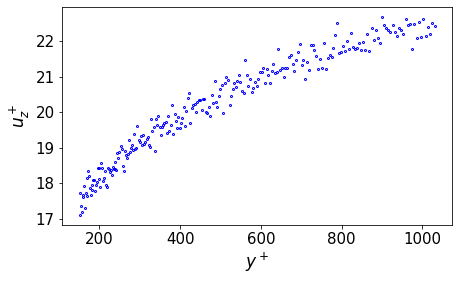

In [5]:
plt.figure(figsize=(7,4))
plt.plot(yp,up,'ob',ms=2)
plt.xlabel(r'$y^+$')
plt.ylabel(r'$u_z^+$')
plt.show()

The corresponding statsitical equation with additive error assumption is written as, 

$$
\begin{equation}
u^+_i = \frac{1}{\kappa}\log(y^+_i) + B + \varepsilon_i \,,\quad i=1,2,\cdots,n
\end{equation}
$$

which can be written in the matrix form as, 

$$
\begin{equation}
  \begin{bmatrix}
  u^+_1\\  u^+_2\\\cdots \\u^+_n
  \end{bmatrix}     
    = 
  \begin{bmatrix}  
  \log(y^+_1) & 1\\
  \log(y^+_2) & 1\\
  \cdots & \cdots\\
  \log(y^+_n) & 1\\
  \end{bmatrix}  
  \begin{bmatrix}
  1/\kappa \\
  B
  \end{bmatrix}
  + 
  \begin{bmatrix}
  \varepsilon_1 \\
  \varepsilon_2 \\
  \cdots\\
  \varepsilon_n 
  \end{bmatrix} \,,
\end{equation}
$$

or, 

$$
\mathbf{Y}=\mathbf{G}\mathbf{\Theta} + \mathcal{E} \,.
$$

Applying the OLS, leads to 

$$
\hat{\mathbf{\Theta}} = (\mathbf{G}^T\mathbf{G})^{-1}\mathbf{G}^T \mathbf{Y}
$$

In [6]:
def logLaw_LSE(yp,up):
    """
    Estimation of kappa and B in the log law using OLSE
    """
    G=np.vstack((np.log(yp),np.ones(len(yp)))).T
    theta=inv(G.T@G)@G.T@up
    return theta,G

In [7]:
theta,Xlog=logLaw_LSE(yp,up)
kap0=1/theta[0]
B0=theta[1]
print('kappa=%g, B=%g'%(kap0,B0))

kappa=0.376371, B=4.02685


We should not see any trend in the residuals. This can be examined by plotting the residuals.

(241,)


Text(0, 0.5, 'Residuals')

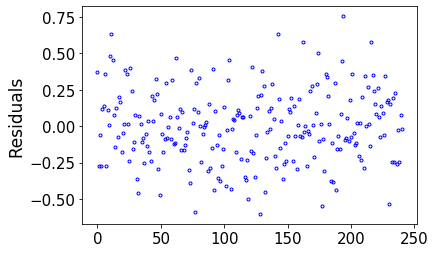

In [8]:
R=up-theta[0]*np.log(yp)-theta[1]
print(R.shape)

plt.plot(R,'ob',ms=3)
plt.ylabel('Residuals')

Next, we estimated the variance of the iid Gaussian noise.

In [9]:
var_log=R.T@R/(n-2)
print('sdev of the noise in the data = %g' %(mt.sqrt(var_log)))

sdev of the noise in the data = 0.249282


Finally, we estimate the confidence interval for the estimated parameters. This can be through the estimation of the covariance matrix of the calibration parameters.

In [10]:
covMat_log=var_log*inv(Xlog.T@Xlog)
print(covMat_log)

[[ 0.00086074 -0.00525659]
 [-0.00525659  0.03236002]]


For a specific percentage of confidence interval, we can look up the multiplier value from the [t-table](https://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf). 
For instance, for $95%$ confidence interval, the multiplier is $1.96$. 

In [11]:
kap_log=[theta[0]-1.96*mt.sqrt(covMat_log[0,0]),theta[0]+1.96*mt.sqrt(covMat_log[0,0])]
B_log=[theta[1]-1.96*mt.sqrt(covMat_log[1,1]),theta[1]+1.96*mt.sqrt(covMat_log[1,1])]

print('95 % CI for 1/kappa = ',kap_log)
print('95 % CI for B = ',B_log)

95 % CI for 1/kappa =  [2.5994476475346193, 2.7144543433497255]
95 % CI for B =  [3.6742671299272773, 4.379431651307393]


Finally, we plot the calibrated log law and the training data. 

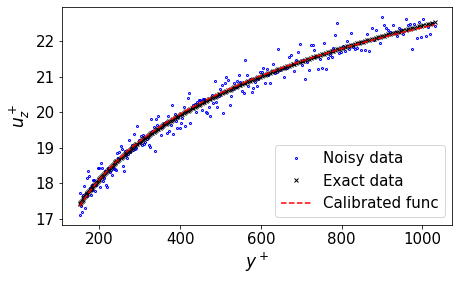

In [12]:
plt.figure(figsize=(7,4))
plt.plot(yp,up,'ob',ms=2,label='Noisy data')
plt.plot(yp,up0,'x k',ms=4,label='Exact data')
plt.plot(yp,theta[0]*np.log(yp)+theta[1],'--r',label='Calibrated func')

plt.legend()
plt.xlabel(r'$y^+$')
plt.ylabel(r'$u_z^+$')
plt.show()

## Example: Projectile Motion (Nonlinear Model)
Consider a projectile of mass $m$ that is projected with initial velocity $v_0$ and angle $\alpha$ (measured from horizontal plane) into the Earth's gravitational field ($g=9.81 \, m^2/s$).
We can show that the projectile's horizontal and vertical locations $x$ and $y$, respectively, over time $t$ are given by (see e.g. [here](https://en.wikipedia.org/wiki/Projectile_motion)):

$$
x=v_0\cos(\alpha)t,
y=v_0\sin(\alpha)t - gt^2/2 \,,
$$
where the initial location is assumed to be at the $x=0$ and $y=0$. 
Removing $t$ between these two expressions leads to the following expression for the projectile's path:

$$
\begin{equation}
y=\tan(\alpha) x - \frac{g}{2v_0^2\cos^2(\alpha)}x^2 = f(x,\mathbf{\Theta}) \,,
\end{equation}
$$

where $\mathbf{\Theta}=[\alpha,v_0]$ and $g=9.81$ is fixed.

The following function is a simple implementation of this expression.

In [13]:
def yProjectile(x,alpha,v0):
    """
    Projectile's vertical position 
    """
    g=9.81
    y=x*mt.tan(alpha)-g*x**2/(2*v0**2*mt.cos(alpha)**2)
    return y

Here, we have three model parameters: $\alpha$, $g$, and $v_0$. Our task here is to infer the values of these parameters given a set of uncertain data for $(x,y)$. 

First, we use `yProjectile()` to create `n` synthetic data for $x$ and $y$. 

In [14]:
nProj=200   #number of synthetic data

#fixed x values
xProj=np.linspace(0,8,nProj)   

#true values of the parameters
alpha0=mt.pi/3
v00=10
noiseLevel=0.3


#create synthetic data
epsProj=np.random.normal(loc=0,scale=noiseLevel,size=nProj)
yProj=yProjectile(xProj,alpha0,v00)+epsProj

Text(0, 0.5, 'y')

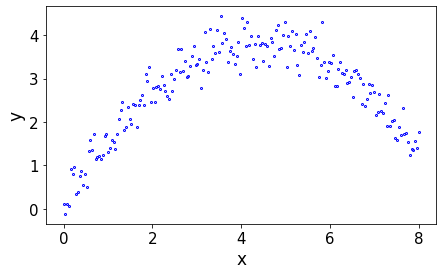

In [15]:
#plot noisy data
plt.figure(figsize=(7,4))
plt.plot(xProj,yProj,'ob',ms=2)
plt.xlabel('x')
plt.ylabel('y')

To estimate $\mathbf{\Theta}=[\alpha,v_0]$ and noise level, we apply the LSE as shortly described above. Given that the dependency of $y$ on the parameters is non-linear, we need to use a non-linear LSE. To this end, we use the existing [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit).

In [16]:
thetaProj, pcovProj = curve_fit(yProjectile, xProj, yProj,bounds=(0,[2,20]),method='dogbox')

The mean of the estimated parameters are the following which can be compared to the associated true values used to create the synthetic data.

In [17]:
print('  Estimated Parameters vs True Values')
print('alpha: %g , %g' %(thetaProj[0],alpha0))
print('v0: %g , %g' %(thetaProj[1],v00))

  Estimated Parameters vs True Values
alpha: 1.04974 , 1.0472
v0: 10.0084 , 10


Plot the residuals: 

In [18]:
Rproj=yProj-yProjectile(xProj,thetaProj[0],thetaProj[1])

Text(0, 0.5, 'Residuals')

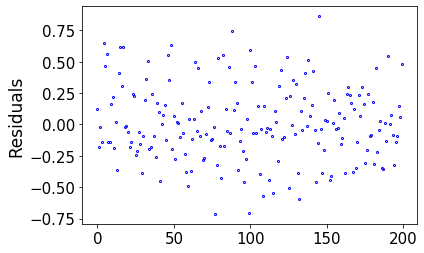

In [19]:
plt.plot(Rproj,'ob',ms=2)
plt.ylabel('Residuals')

The variance of the Gaussian noise can be estimated as,

In [20]:
var_proj=Rproj.T@Rproj/(n-2)
print('sdev of the noise in the data = %g' %(mt.sqrt(var_log)))

sdev of the noise in the data = 0.249282


Since the projectile $y$ is a non-linear of parameters $\mathbf{\Theta}$, we need to compute the local sensitivities of $y$ to the parameters in order to obtain an estimate for the covariance matrix of the estimated parameters. The local sensitivities are derived as,

$$
\begin{eqnarray}
\frac{\partial f}{\partial \alpha} &=& \frac{x}{\cos^2(\alpha)} -\frac{g x^2 \sin(\alpha)}{v_0^2\cos^3(\alpha)} \,, \\
\frac{\partial f}{\partial v_0} &=& \frac{g x^2}{v_0^3\cos^2(\alpha)} \,.
\end{eqnarray}
$$

Using the training data $\{(x_i,y_i)\}_{i=1}^n$, the $ n\times 2$ sensitivity matrix $\mathbf{X}$ is constructed, where $X_{ij}(\mathbf{\Theta}) = \frac{\partial f(x_i,\Theta)}{\partial \Theta_j}$ evaluated at the mean of the estimated parameters. 

In [21]:
def projectile_sensMatrix(x,param):
    """
    Compute the sensitivity matrix of the projectile model function at x and given parameters
    """
    g=9.81
    alpha=param[0]    
    v0=param[1]
        
    X_alpha=x/mt.cos(alpha)**2 - g*x**2*mt.sin(alpha)/(v0**2*mt.cos(alpha)**3)
    X_v0=g*x**2/(v0**3*mt.cos(alpha)**2)
    X=np.vstack((X_alpha,X_v0)).T
    return X

In [22]:
Xproj=projectile_sensMatrix(xProj,thetaProj)
print(Xproj.shape)

(200, 2)


Using the estimated noise variance and the sensitivity matrix, the covariance of the estimated parameters can be computed. Note that `scipy.optimize.curve_fit` also returns `pcovProj` which should be identical with what we compute here.

In [23]:
covMat_proj=var_proj*inv(Xproj.T@Xproj)
print('Covaraince matrix of the parameters:')
print('Computed:',covMat_proj)
print('Scipy:',pcovProj)

Covaraince matrix of the parameters:
Computed: [[1.70658592e-05 2.57608641e-05]
 [2.57608641e-05 3.27512498e-04]]
Scipy: [[2.05996976e-05 3.10951901e-05]
 [3.10951901e-05 3.95330778e-04]]


The $95\%$ confidence interval of the estimated parameters can be computed.

In [24]:
alpha_proj=[thetaProj[0]-1.96*mt.sqrt(covMat_proj[0,0]),thetaProj[0]+1.96*mt.sqrt(covMat_proj[0,0])]
v0_proj=[thetaProj[1]-1.96*mt.sqrt(covMat_proj[1,1]),thetaProj[1]+1.96*mt.sqrt(covMat_proj[1,1])]


print('95 % CI for alpha = ',alpha_proj)
print('95 % CI for v0 = ',v0_proj)

95 % CI for alpha =  [1.0416448913520464, 1.0578387425989464]
95 % CI for v0 =  [9.97291521877793, 10.043856659749308]


Finally, we can plot the calibrated function to compare with the true values and training data.

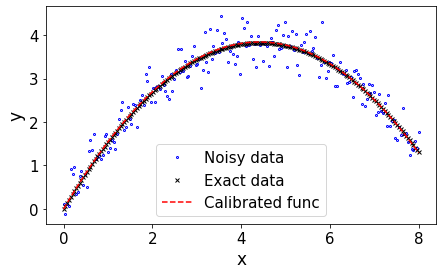

In [25]:
plt.figure(figsize=(7,4))
plt.plot(xProj,yProj,'ob',ms=2,label='Noisy data')
plt.plot(xProj,yProjectile(xProj,alpha0,v00),'x k',ms=4,label='Exact data')
plt.plot(xProj,yProjectile(xProj,thetaProj[0],thetaProj[1]),'--r',label='Calibrated func')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Hands-on: Damped Harmonic Oscillation

Consider the simple system consisting of a mass $m$, a damper with damping coefficient $c$, and a spring with constant $k$. For the oscillations with no forcing in the vertical direction, the dynamics of the system is described by the following 2nd-order ODE:
    
$$
\begin{equation}
\ddot{y} + C \dot{y} + K y =0 \,, \quad y(0)=y_0 \,, \dot{y}(0)=v_0
\end{equation}
$$

where $y$ is the distance from the fixed point at the top, $C=c/m$, and $K=k/m$. The analytical solution for the above ODE is,

$$
\begin{equation}
   y(t)=\exp(-C\,t/2) \left(c_1\cos(\omega t) + c_2 \sin(\omega t) \right)
\end{equation}
$$

where $c_1=y_0$, $c_2=(v_0+C y_0/2)/\omega$, and $\omega = \sqrt{K-C^2/4}$. 

In [26]:
def yHarmOscil(t,y0,v0,K,C):
    """
    Computes `y` of the damped harmonic oscillator
    """
    c1=y0
    
    omeg=K-C**2/4
    if (omeg>=0):
       omeg=mt.sqrt(omeg)
    else:
       raise ValueError ('Overdamped case. K >= C^2/4 is not satisfied.')

    c2=(v0+C*y0/2)/omeg
    y=np.exp(-C*t/2)*(c1*np.cos(omeg*t)+c2*np.sin(omeg*t))
    return y

In [27]:
n=200
t=np.linspace(0,5,n)
C0=2
K0=100
y00=0
v00=2
noise=0.01*np.random.normal(size=n)
y=yHarmOscil(t,y00,v00,K0,C0)+noise

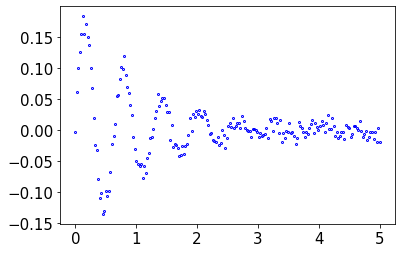

In [28]:
#plot training data
plt.plot(t,y,'ob',ms=2)

## Hands-on: The Spalding Law
In 1961, [Spalding](https://asmedigitalcollection.asme.org/appliedmechanics/article-abstract/28/3/455/386110/A-Single-Formula-for-the-Law-of-the-Wall?redirectedFrom=fulltext) proposed a single composite profile that covers the viscous sublayer, buffer layer and logarithmic region of an equilibrium boundary layer. Contrary to other attempts, Spalding tried to express $y^+$ in terms of $u^+$:
\begin{equation}\label{eq:spaldinglaw}
y^+=u^+ + e^{-\kappa B}\left[e^{\kappa u^+} - \sum_{m=0}^{N_{S}} \frac{(\kappa u^+)^m}{m!}\right]
\end{equation}
where $N_{S}$ was suggested to be either $3$ or $4$ without any known advantage of one over the other.

In [29]:
def dataSelector_SapldingLaw(Re,db):
    """
    Select y+ within a given range
    """    
    db_=db['Re'+str(Re)]
    I=np.where(db_['y+']<0.2*Re)[0]    
    return db_['uTau'],db_['y+'][:I[-1]],db_['Uz+'][:I[-1]]

#extract the (y+,u+) data in the range of validity of the wall function
uTau,yp,up=dataSelector_SapldingLaw(5200,db)

In [30]:
up+=0.3*np.random.normal(size=up.shape[0])

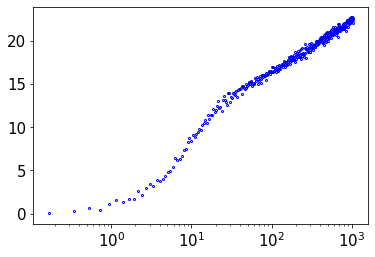

In [31]:
plt.semilogx(yp,up,'ob',ms=2)